In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

#import numpy as np
import pandas as pd
import spacy

from sklearn.model_selection import train_test_split
from sklearn import metrics
import string

import random
random.seed(123)

In [2]:
# import data
data = pd.read_csv('../../events/group_all_labelled.csv',
    usecols=['event_id','filename', 'group', 'sentence_text','event_text', 'Near Miss Event', 'reviewed'])

df = data.loc[data.reviewed].reset_index(drop=True)  # had a missing index
df['labels'] = df['Near Miss Event'].astype(int)

# stratified sampling with indices (instead of data) and labels
train_idx, test_idx, train_labels, test_labels = train_test_split(
    df.index, df.labels, test_size=0.3, stratify=df.labels.values)

In [3]:
from capstone import load_spacy_model

nlp = load_spacy_model(output_type='text', tokenizer_only=True)

sample_text = 'Jane was leading the race - she was going to win the gold medal.'

Added lemmatizer pipe
Added stopwords and punctuation pipe
Loading spaCy model with list of token text strings as output.
Loading tokenizer only - disabling: ['tagger', 'parser', 'ner'].


In [6]:
### CLASSIFICATION ###

from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_array, check_is_fitted
import numpy as np

class CosineMeanClassifier(BaseEstimator, ClassifierMixin):
    """ 
    https://scikit-learn.org/stable/developers/develop.html
    sci-kit Learn compatible classifier that implements classification based on cosine similarity.

    Classifier is fit to a n x m numpy vector (n = number of observations, m = number of column vectors)

    Parameters
    ----------
    cut_off : float, default=0.5
        A parameter used to determine cut-off threshold for prediction.
    Attributes
    ----------
    n_features_ : int
        The number of features of the data passed to :meth:`fit`.
    mean_vector : np.array
        The mean vector of the input data fitted to the classifier.

    Example usage:
    >> from capstone import CosineMeanClassifier     
    >> from sklearn.feature_extraction.text import TfidfVectorizer
    >> from sklearn.decomposition import TruncatedSVD
    >> from sklearn.pipeline import Pipeline

    >> cosine_pipeline = Pipeline([
        ('tfidf', TfidfVectorizer(min_df=2, tokenizer = nlp, sublinear_tf = True)),  # outputs (n x v) array
        ('svd', TruncatedSVD(n_components=50)),  # outputs n x 50 array
        ('cosine', CosineMeanClassifier(cut_off=0.5))
    ])

    >> cosine_pipeline.fit(event_text)  # event text is a pd.Series or np.array of strings
    Pipeline(steps=[('tfidf',
                 TfidfVectorizer(min_df=2, sublinear_tf=True,
                                 tokenizer=<spacy.lang.en.English object at 0x7f7de6d47f70>)),
                ('svd', TruncatedSVD(n_components=50)),
                ('cosine', CosineMeanClassifier())])

    >> cosine_pipeline.predict(df.event_text.values)
    array([0, 0, 0, ..., 0, 0, 1])
    """

    def __init__(self, cutoff=0.5):
        self.cutoff = cutoff  # threshold cut-off for classification : cosine distance is bounded [0,1]

    def fit(self, X, y=None):  # Does not involve labels - we are just using mean vector like a nearest neighbor
        """A reference implementation of a fitting function for a transformer.
        Parameters
        ----------
        X : {array-like, sparse matrix}, shape (n_samples, n_features)
            The training input samples.
        y : None
            There is no need of a target in a transformer, yet the pipeline API
            requires this parameter.
        Returns
        -------
        self : object
            Returns self.
        """
        self.mean_vector = X.mean(axis=0)
        self.n_features_ = X.shape[1]
        return self # Return the classifier
    
    def transform(self, X, y=None):
        """ A reference implementation of a transform function.
        Parameters
        ----------
        X : {array-like, sparse-matrix}, shape (n_samples, n_features)
            The input samples.
        Returns
        -------
        X_transformed : array, shape (n_samples, 1)
            The array containing the cosine similarities of the input samples.
            in ``X``.
        """
        # Check is fit had been called
        check_is_fitted(self, 'n_features_')
        X = check_array(X)  # input validation
        
        # Check that the input is of the same shape as the one passed during fit.
        if X.shape[1] != self.n_features_:
            raise ValueError('Shape of input is different from what was seen'
                             'in `fit`')
            
        # compute cosine similarity
        magnitude = lambda x : np.sqrt(np.sum(np.power(x,2)))  # utility function to calculate magnitude
        similarity = lambda a, b : (np.dot(a, b)) / (magnitude(a)*magnitude(b)) 
        
        return np.array([similarity(x, self.mean_vector) for x in X])
    
    def predict_proba(self, X):
        """ A reference implementation of a transform function.
        Parameters
        ----------
        X : {array-like, sparse-matrix}, shape (n_samples, n_features)
            The input samples.
        Returns
        -------
        X_transformed : array, shape (n_samples, 1)
            The array containing the cosine similarities of the input samples.
            in ``X``.
        """
        return self.transform(X)
    
    def predict(self, X):
        """ A reference implementation of a transform function.
        Parameters
        ----------
        X : {array-like, sparse-matrix}, shape (n_samples, n_features)
            The input samples.
        Returns
        -------
        X_transformed : array, shape (n_samples, 1)
            The array containing a predictions based on taking a boolean condition cosine similarities of the input samples
            in ``X``. If the cosine similiarity is greater than self.cutoff, then return 1, else 0.
        """
        # Check is fit had been called
        check_is_fitted(self, 'n_features_')
        X = check_array(X)  # input validation
        
        # Check that the input is of the same shape as the one passed during fit.
        if X.shape[1] != self.n_features_:
            raise ValueError('Shape of input is different from what was seen'
                             'in `fit`')

        # compute cosine similarity
        magnitude = lambda x : np.sqrt(np.sum(np.power(x,2)))  # utility function to calculate magnitude
        similarity = lambda a, b : (np.dot(a, b)) / (magnitude(a)*magnitude(b)) 
        
        # apply mean vertically over col and return a (1,n) vector,  return binary integer array
        return np.array([(similarity(x, self.mean_vector) > self.cutoff) for x in X], dtype=np.int64)
    
    def fit_transform(self, X, y=None):
        self.fit(X)
        return self.transform(X)

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import Pipeline
import numpy as np

cutoffs = np.linspace(0., 1.0, 201)
data = []

# we dont need to recreate this vectorizer pipeline for each cutoff
vectorizer = Pipeline([
        ('tfidf', TfidfVectorizer(min_df=2, tokenizer = nlp, sublinear_tf = True)),
        ('svd', TruncatedSVD(n_components=50))])

# vectorize train and test text
train = vectorizer.fit_transform(df.loc[train_idx].event_text)
test = vectorizer.fit_transform(df.loc[test_idx].event_text)

# loop through cutoffs to see accuracy
for cutoff in cutoffs:
    clf = CosineMeanClassifier(cutoff=cutoff)
    
    # fit text to find mean vector then predict given cutoff
    clf.fit(train)  # fit to training data
    predictions = clf.predict(test)  # predict on test data
    
    # append prediction scores for a given vectorisation + threshold
    # we set zero_diviosn=0 to suppress warnings when all labels are predicted to be 0 (causing zero division)
    data.append({'accuracy': metrics.accuracy_score(test_labels, predictions),
    'precision' : metrics.precision_score(test_labels, predictions, zero_division=0),
    'recall' : metrics.recall_score(test_labels, predictions, zero_division=0),
    'f_score' : metrics.f1_score(test_labels, predictions, zero_division=0)})

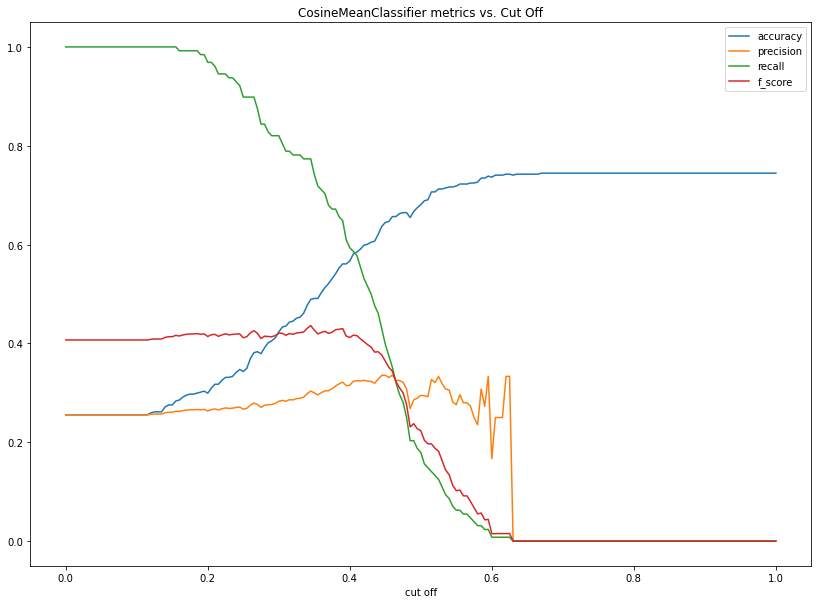

In [5]:
results = pd.DataFrame(data, index=cutoffs)
results.plot(figsize=(14,10), title='CosineMeanClassifier metrics vs. Cut Off',xlabel='cut off')

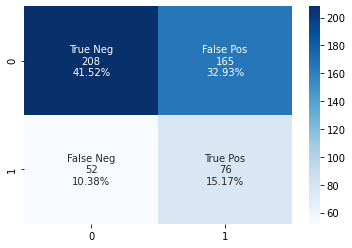

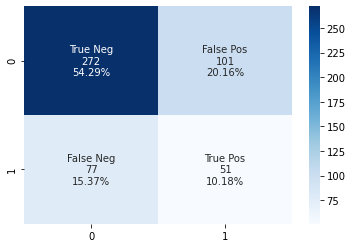

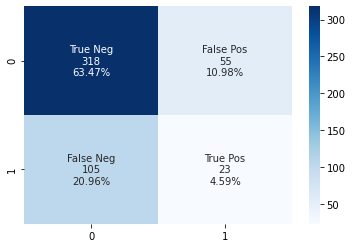

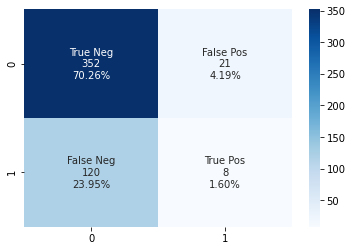

In [12]:
from sklearn.metrics import confusion_matrix#, classification_report, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

for cutoff in (0.4, 0.45, 0.5, 0.55):
    clf = CosineMeanClassifier(cutoff=cutoff)

    # fit text to find mean vector then predict given cutoff
    clf.fit(train)  # fit to training data
    predictions = clf.predict(test)

    cm = confusion_matrix(test_labels, predictions)

    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ['{0:0.0f}'.format(value) for value in cm.flatten()]
    group_percentages = ['{0:.2%}'.format(value) for value in
                         cm.flatten()/np.sum(cm)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
              zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')
    plt.show()